
<b>Описание проекта:</b>

В работе необходимо выявить факторы, определяющие успешность игр, чтобы правильно спланировать рекламные компании для интернет-магазина.  

<b>Входные данные</b>:  
  
Данные, с которыми мне предстоит работать, представляют собой dataset и содержат следующую информацию:
• Name — название игры  
• Platform — платформа  
• Year_of_Release — год выпуска  
• Genre — жанр игры  
• NA_sales — продажи в Северной Америке (миллионы долларов)  
• EU_sales — продажи в Европе (миллионы долларов)  
• JP_sales — продажи в Японии (миллионы долларов)  
• Other_sales — продажи в других странах (миллионы долларов)  
• Critic_Score — оценка критиков (от 0 до 100)  
• User_Score — оценка пользователей (от 0 до 10)  
• Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

<b>План работы включает в себя</b>:

1) Произвести первичную обработку данных данных    
2) Провести исследовательский анализ данных  
3) Составить портеры пользователей   
4) Провести исследование различных статистических показателей  
5) Проверить статистические гипотезы  
    <div>

### Шаг 1. Получим данные

In [1]:
# Импорт необходимых библиотек

import numpy as np # Для быстрых и сложных математических операций
import pandas as pd # База анализа данных
import matplotlib.pyplot as plt # Кастомизация графиков
import plotly.express as px # Крутые интерактивные графики
from plotly.offline import init_notebook_mode, iplot # для офлайн отображения plotly графиков
from datetime import datetime
from scipy import stats as st
import math
%matplotlib inline

In [2]:
# Читаем данные и смотрим на них

games_data = pd.read_csv('/datasets/games.csv')
games_data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Шаг 2. Изучим общую информацию о данных

In [3]:
games_data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [4]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В DataFrame'е 16713 строк, есть пропущенные значения, типы данных, в основном числовые. Также встречаются строчные

In [5]:
# Посмотрим на пропущенные значения

games_data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
# И дубликаты

games_data.duplicated().sum()

0

### Предподготовка данных:

#### Заменим названия столбцов на более удобные

In [7]:
games_data.columns = [x.lower() for x in games_data.columns]
games_data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Посчитаем суммарные продажи

In [8]:
games_data['total_sales'] = games_data[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

In [9]:
games_data.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24


#### Изменим типы данных и поработаем с пропусками

In [10]:
games_data.info()

# year_of_release привёдём к формату int
# user_score приведём к формату float

games_data['year_of_release'].isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
total_sales        16715 non-null float64
dtypes: float64(7), object(5)
memory usage: 1.5+ MB


269

In [11]:
# Проусщенных значений в годах довольно мало. Заменим значения в них на случайные
games_data['year_of_release'] = games_data['year_of_release'].fillna(2110) \
                                                             .astype('int')
games_data = games_data[games_data['year_of_release'] != 2110]

In [12]:
games_data.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54


In [13]:
# Посмотрим теперь на столбец user_score
games_data['user_score'].unique()

# Как видно, есть значение tbd, которое будет мешать привести колонку к формату float
# Посмотрим, можно ли от них избавиться

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [14]:
games_data[games_data['user_score']=='tbd'].shape[0]
# Таких значений довольно много. Заменим их на пустые значения

games_data['user_score'] = games_data['user_score'].replace('tbd',np.nan)

In [15]:
# Приведём к формату float
games_data['user_score'] = games_data['user_score'].astype('float',errors='ignore')

In [16]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16446 non-null object
year_of_release    16446 non-null int64
genre              16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
total_sales        16446 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


In [17]:
# Посмотрим, сколько у нас пропущенных значений

games_data.isnull().sum().sort_values(ascending = False)

user_score         8983
critic_score       8463
rating             6678
genre                 2
name                  2
total_sales           0
other_sales           0
jp_sales              0
eu_sales              0
na_sales              0
year_of_release       0
platform              0
dtype: int64

Нужно решить, что делать с пропусками в 4-х столбцах.   
*Начнём с user_score. Давайте заполним его числом, но таким, чтобы оно не смешивалось с нулевым рейтингом. Например, отрицательным (-1)*  
*critic_score заполним аналогично  
Пропуском в рейтинге достаточно много, можем присвоить им отдельную категорию  
Пропуски в name и genre можем удалить, так как их всего по два, на данные это сильно не повлияет*  

In [18]:
games_data['user_score'] = games_data['user_score'].fillna(-1)
games_data['critic_score'] = games_data['critic_score'].fillna(-1)
games_data['rating'] = games_data['rating'].fillna('out_of_rating')
games_data = games_data.dropna(axis=0)

In [19]:
games_data.isnull().sum().sort_values(ascending = False)

total_sales        0
rating             0
user_score         0
critic_score       0
other_sales        0
jp_sales           0
eu_sales           0
na_sales           0
genre              0
year_of_release    0
platform           0
name               0
dtype: int64

In [20]:
games_data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,out_of_rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,out_of_rating,31.38


### Шаг 4. Проведите исследовательский анализ данных

#### Посмотрим сколько игр выпускалось в разные годы

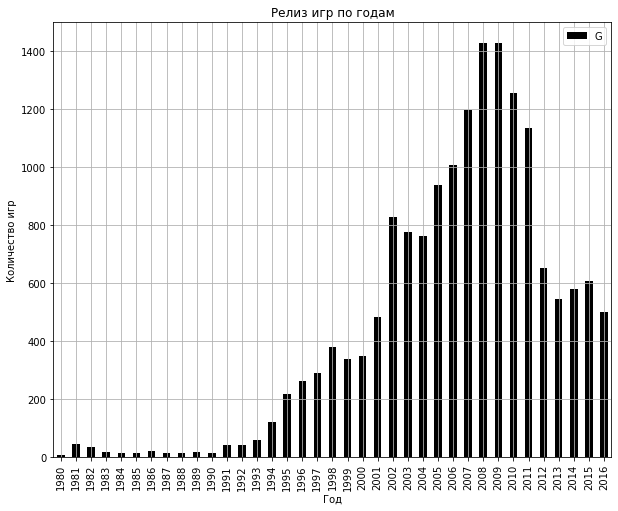

In [21]:
games_data[games_data['year_of_release']!=2110].groupby('year_of_release') \
          .agg({'name':'count'}) \
          .plot(kind='bar', 
                figsize=(10,8),
                grid=True, 
                color='k')
plt.title('Релиз игр по годам')
plt.ylabel('Количество игр')
plt.legend('Games')
plt.xlabel('Год');

Выводы:  
до 1993 года игры не получали широково распространения в виду того, что платформеры являлись инструментом роскоши, плюс, не было достаточно специалистов для создания игр, а само создание было ограничено слабыми мощностями платформ.  
После 2009 индустрия уходит на спад, становится всё меньше игр.  
На мой взгляд связано это с кризисом 2008, что сказалось на производстве всех товаров, не только игр.  

Нам наверняка не важны данные до 1993 года. Во-первых, потому что игр выпускалось достаточно мало.  
Из-за этого любая выпущенная игра могла стать успешной. Плюс ко всему, по ним нельзя будет делать   
реперезентативные статистические выводы.

#### Посмотрим, как менялись продажи по платформам. 
Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.

In [22]:
platforms = games_data.groupby(by=['platform','year_of_release'],as_index=False)['total_sales'] \
                            .sum() \
                            .sort_values('total_sales',ascending=False)
platforms

,platform,year_of_release,total_sales
134,PS2,2004,211.81
200,Wii,2009,206.97
132,PS2,2002,205.38
133,PS2,2003,184.31
199,Wii,2008,171.32
...,...,...,...
94,PC,1988,0.03
119,PCFX,1996,0.03
23,DC,2007,0.02
10,3DO,1994,0.02


In [25]:
# Найдём число уникальных платформ
platforms['platform'].unique() 

array(['PS2', 'Wii', 'X360', 'PS', 'PS3', 'DS', 'PS4', 'GBA', 'XB', 'GB',
       '3DS', 'XOne', 'N64', 'PSP', 'NES', 'GC', 'SNES', '2600', 'PC',
       'WiiU', 'PSV', 'GEN', 'SAT', 'DC', 'SCD', 'NG', 'WS', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Теперь узнаем, какие платформы имеют нулевые продажи к 2016 году.  
Такими являются все, кроме:   
• XBOX360  
• PS3  
• Wii  
• PSV  
• 3DS  
• WiiU  
• PS4  
• XOne   
• PC  
• *PSP, но их продажи заканчиваются в 2015, возможно есть надежда, что она вдохнёт новой жизнью, как это было с Nes в 1987*

Теперь время посчитать, с какой периодичностью появляются новые и исчезают старые платформы. Для этого найдём среднюю частоту появления платформ одного производителя для разных производителей и посчитаем их общее среднее. *На мой взгляд, не следует обобщать выход игровых платформ всех производителей, потому что даже если выйдет условная PS5, игры для последней Xbox всё ещё будут актуальны для тех, у кого есть Xbox. Продажи не перетекут из одного в другое.* 

##### Частота обновления игровых платформ
Раз уж у нас на высоте сейчас приставки серии Playstation, Xbox и Nintendo, то нет особо смысла смотреть на частоту тренда остальных.  
   
• Playstation (приставки) - 1994 (PS), 2000 (PS2), 2006 (PS3), 2013 (PS4)    
Mu = 6+6+7 ~ 6 лет   
  
• Playstation (портативные консоли) - 2004 (PSP), 2011 (PSV) - Данных мало, нет закономерности

• Xbox - 2000 (XB), 2005 (Xbox360), 2013 (XOne)  
Mu = ~ 7 лет
  
• Nintendo (игровые устройства) -  1985 (NES), 1990 (SNES), 1996 (Nintendo 64), 2001 (GameCube), 2006 (Wii), 2012 (WiiU)  
Mu = ~5 лет
  
• Nintendo (портативные консоли) -  1985 (DS), GB (1988), 3DS (2011) - Данных мало, нет закономерности
  
Итого: средняя частота выхода игровых платформ ~ 6 лет

Подсчитаем средний срок жизни всех платформы:  
PSP - 2015-2004 = 11  
GC - 2007 - 2001 = 6  
XB - 2008 - 2000 = 8  
PS2 - 2011 - 2000 = 11  
DC - 2008 - 1998 = 10  
GBA - 2007 - 2000 = 7  
WS - 2001-1999 = 3  
N64 - 6  
3DO - 1  
PS - 11  
SAT - 5  
SCD - 1  
NG -3  
SNES - 9  
GEN - 4  
GB - 3  
PC - 31  
DS - 28  
NES - 11  
2600 - 9  

In [26]:
platform_life = [11,6,8,11,10,7,3,6,1,11,5,1,3,9,4,3,31,28,11,9]
platform_life = pd.Series(platform_life)
print(f'Срднее равно: {platform_life.mean()}')
print(f'Медиана равна: {platform_life.median()}')
print(f'Дисперсия равна: {np.var(platform_life)}')
print(f'Стандартное отклонение равно: {math.sqrt(np.var(platform_life))}')

Срднее равно: 8.9
Медиана равна: 7.5
Дисперсия равна: 58.09000000000001
Стандартное отклонение равно: 7.621679604916491


<b>Выводы по срокам жизни</b>  
Исходя из того, что есть значительные выбросы в обе стороны (1 год и 31 год), то медиану рассматривать более реперзентативно. Видно, что медианный срок жизни платформы - это 7,5 лет  
Значит платформа живёт в среднем полтора года после того, как появляется новая версия

#### Чтобы избежать искажения, давайте возьмём данные не за весь период, а с определённым срезом  
Как я писал ранее, основное развитие игровой индустрии, появление разнообразия игр, оценок критиков и геймеров началось после 1997 года. Тогда, на рынке было много игр, и покупались по-настоящему успешные. Плюс ко всему, продажи игр до 2000 года можно объяснить их уникальностью, что я определил как критерий успеха. Поэтому давайте сделаем срез по 2000 году

In [27]:
games_data = games_data[games_data['year_of_release']>2000]
games_data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
total_sales        0
dtype: int64

#### Выберем потенциально прибыльные платформы
*Топ по продажам в 2016 (однако все они сейчас падают):*  
1) PS4 (69,25) - падение < 50%, началось лишь в 2015, следующая консоль поколения выйдет примерно через 3-4 года.  
2) XOne (26,15) - падение сильное (>50%), началось лишь в 2015, но следующая консоль поколения выйдет примерно через 3-4 года.   
3) 3DS (15,14) - падает с 2013, с прошлого года практически на 50%      
4) PC (5,25) - падение относительно не сильное. Платформа на плаву с 1985 года, ранее бывали резкие скачки.   
5) WiiU (4,6) - начала падать с 2014; с 2015 упала более чем на 50%    
6) PSV (4,25) - падение с 2014; в 2015 стало не столь стремительным; бывали периоды взлёта.  
7) PS3 (3,6) - падает с момента выхода PS4, был небольшой подъем, с каждым годом падение корректируется      
8) Xbox 360 (1,52) - падение с 2010, но с каждым годом уменьшалось. Был резкий взлёт    
9) Wii (0,18) - падение началось в 2009; сейчас падение минимальное 
  

Исходя из данных выше, считаю нужным на всю котлету вложиться в PS4 и XOne из-за самой высокой капитализации продажи игр; PC за счёт хорошего тренда PSV за счёт неплохих показателей

#### Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. 
  
Опишем результаты

In [28]:
pivot_games_data = games_data.pivot_table(index='name',
                       columns='platform',
                       values='total_sales',
                       aggfunc='sum')

pivot_games_data

platform,3DS,DC,DS,GB,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,PSV,WS,Wii,WiiU,X360,XB,XOne
name,,,,,,,,,,,,,,,,,,,,
Beyblade Burst,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fire Emblem Fates,1.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Frozen: Olaf's Quest,0.59,NaN,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Haikyu!! Cross Team Match!,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tales of Xillia 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
thinkSMART FAMILY!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,NaN
thinkSMART: Chess for Kids,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uDraw Studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.42,NaN,NaN,NaN,NaN


In [30]:
pivot_games_data.describe()

platform,3DS,DC,DS,GB,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,PSV,WS,Wii,WiiU,X360,XB,XOne
count,512.000000,11.000000,2120.000000,10.000000,810.000000,542.000000,10.000000,909.000000,114.000000,2045.000000,1305.000000,392.000000,1193.000000,429.000000,2.000000,1286.000000,147.000000,1231.000000,802.000000,247.000000
mean,0.503535,0.129091,0.378660,0.924000,0.386185,0.362970,0.333000,0.221188,0.388860,0.584054,0.713670,0.801378,0.242691,0.125431,0.140000,0.692986,0.559116,0.780861,0.312444,0.645020
std,1.441271,0.103967,1.436359,0.769664,0.900141,0.693974,0.258373,0.587406,0.555121,1.154305,1.403477,1.609456,0.522019,0.212341,0.155563,3.165022,1.058836,1.633605,0.539115,1.036139
min,0.010000,0.020000,0.010000,0.070000,0.010000,0.010000,0.080000,0.010000,0.020000,0.000000,0.000000,0.010000,0.010000,0.010000,0.030000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.050000,0.045000,0.050000,0.202500,0.052500,0.060000,0.152500,0.020000,0.090000,0.080000,0.110000,0.060000,0.030000,0.020000,0.085000,0.090000,0.080000,0.110000,0.060000,0.060000
50%,0.120000,0.120000,0.110000,0.725000,0.160000,0.150000,0.235000,0.040000,0.155000,0.230000,0.280000,0.200000,0.090000,0.050000,0.140000,0.190000,0.220000,0.280000,0.150000,0.220000
75%,0.332500,0.170000,0.270000,1.687500,0.390000,0.367500,0.425000,0.150000,0.437500,0.560000,0.760000,0.730000,0.230000,0.130000,0.195000,0.487500,0.525000,0.770000,0.337500,0.685000
max,14.600000,0.330000,29.800000,1.920000,15.840000,7.060000,0.770000,8.010000,3.730000,20.810000,21.050000,14.630000,7.680000,1.960000,0.250000,82.540000,7.090000,21.820000,8.480000,7.390000


Посмотрим более наглядно, как соотносятся друг с другом медианы и средние по продажам

Text(0.5, 1.0, 'Средние продаж разных платформ')

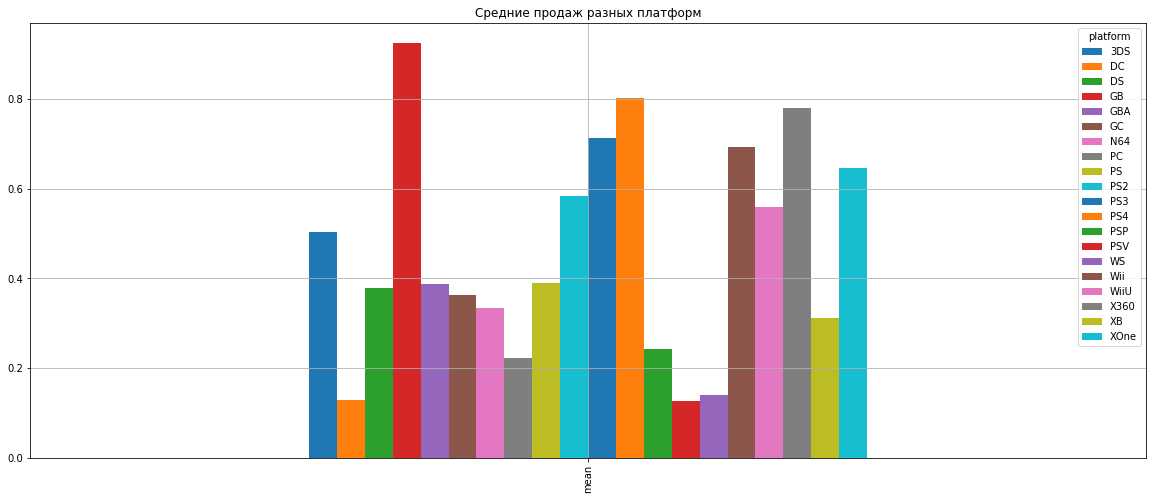

In [31]:
pivot_games_data.describe()[1:2].plot(kind='bar',figsize=(20,8), grid=True);
plt.title('Средние продаж разных платформ')

Выводы:  
1) Средние для WS,PSV и DC примерно на одинаковом низком уровне (< 0.2)  
2) Самые высокие средние у GB, PS3, PS4, Wii, Xbox 360, XOne  (> 0.6)  
3) У WiiU, 3DS и PS2 средние между 0.4 и 0.6  
4) У остальных платформ средние между 0.2 и 0.4  

Text(0.5, 1.0, 'Медианные продажи разных игровых платформ')

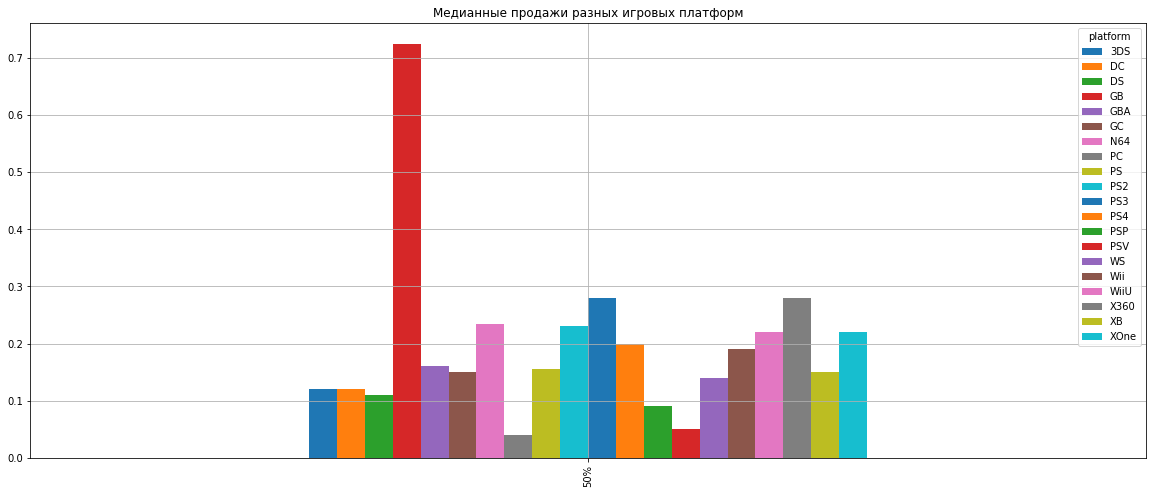

In [32]:
pivot_games_data.describe()[5:6].plot(kind='bar',figsize=(20,8), grid=True);
plt.title('Медианные продажи разных игровых платформ')

Выводы:  
1) Медиана для GB самая высокая.   
2) Медианы для N64, PS2, PS3, WiiU и Xbox 360, PS4 между 0.2 и 0.3  
3) Медианные продажи для PC самые минимиальные, равно как и для PSV   
  
  
Исходя из этой информации, мы откажемся выпускаться на PC и PSV, потому что их высокие результаты не обеспечены высокими мерами центральной тендеции. Возможно вышла какая-то хайповая игра, что на выбросе выдало продажи для платформ; нет никакой стабильности

#### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
  
Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы и соотнесем их с продажами игр на других платформах.

In [33]:
games_data_scores_to_sales = games_data.drop(columns=['name','year_of_release','genre','na_sales',
                                                     'eu_sales','jp_sales','other_sales','rating'])
#games_data_scores_to_sales['user_score'].replace('tbd', None,inplace=True)
#games_data_scores_to_sales.fillna(games_data_scores_to_sales['user_score'].median(),inplace=True)
games_data_scores_to_sales.head()

,platform,critic_score,user_score,total_sales
0,Wii,76.0,8.0,82.54
2,Wii,82.0,8.3,35.52
3,Wii,80.0,8.0,32.77
6,DS,89.0,8.5,29.80
7,Wii,58.0,6.6,28.91


In [34]:
games_data_scores_to_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14120 entries, 0 to 16714
Data columns (total 4 columns):
platform        14120 non-null object
critic_score    14120 non-null float64
user_score      14120 non-null float64
total_sales     14120 non-null float64
dtypes: float64(3), object(1)
memory usage: 551.6+ KB


In [35]:
### Приведём user_score к числовому формату
games_data_scores_to_sales['user_score']=pd.to_numeric(games_data_scores_to_sales['user_score'], errors='coerce')

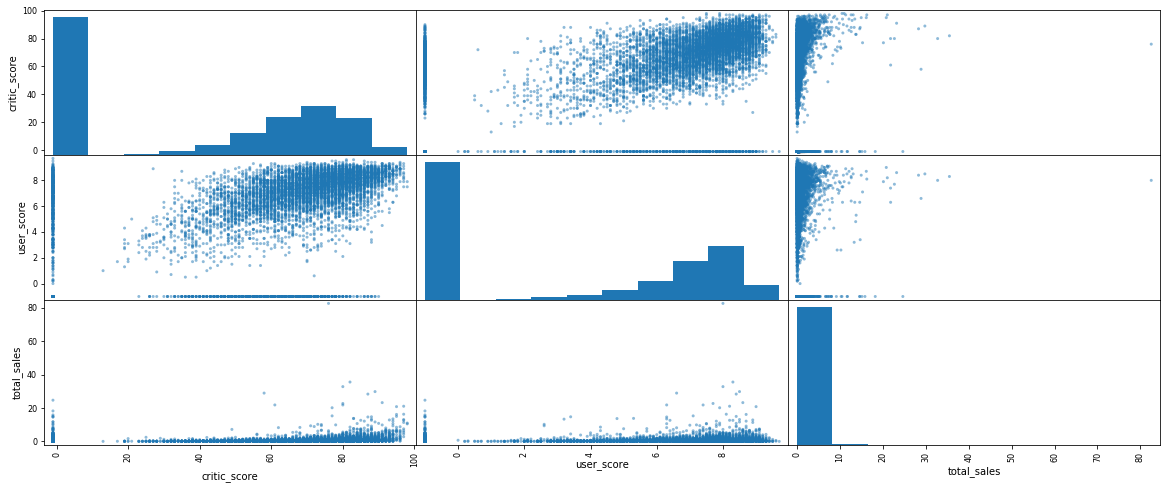

In [36]:
# Построим диаграмму рассеивания для числовых величин
pd.plotting.scatter_matrix(games_data_scores_to_sales, figsize=(20,8));

In [37]:
### Посмотрим корреляционную таблицу

games_data_scores_to_sales.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.799893,0.196515
user_score,0.799893,1.000000,0.178896
total_sales,0.196515,0.178896,1.000000


In [38]:
### Теперь посмотрим на влияние оценок критиков и пользователей на продажи ПО ПЛАТФОРМАМ

games_data_scores_to_sales['platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', 'PS2', 'GBA', 'PS4', '3DS', 'XB', 'PC',
       'PSP', 'XOne', 'WiiU', 'GC', 'PS', 'PSV', 'GB', 'N64', 'DC', 'WS'],
      dtype=object)

Посмотрим на корреляцию между отзывами и продажами на различных платформах. Как видно, самая сильная корреляция наблюдается между отзывами пользователей и оценками критиков практически для всех платформ. Корреляции между продажами и отзывами практически не наблюдается. 

In [70]:
import seaborn as sns

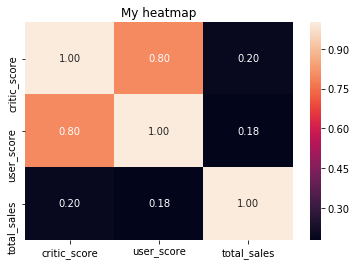

In [72]:
plt.title('My heatmap')
sns.heatmap(
    games_data_scores_to_sales.corr(),
    fmt='.2f',
    annot=True
)

#### Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [40]:
games_data.groupby('genre',as_index=False)['total_sales'].sum().sort_values(by='total_sales',ascending=False)

,genre,total_sales
0,Action,1492.18
10,Sports,1089.68
8,Shooter,905.87
3,Misc,702.80
7,Role-Playing,702.17
6,Racing,541.06
4,Platform,478.37
9,Simulation,332.04
2,Fighting,291.64
1,Adventure,180.78


Как видно, самыми прибыльными жанрами являются игры жанра эшкен, спортивные, а также шутеры.

### Составьте портрет пользователя каждого региона

#### Найдём предпочтительные платформы

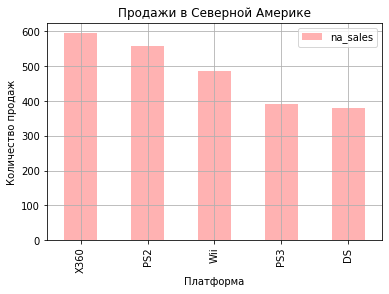

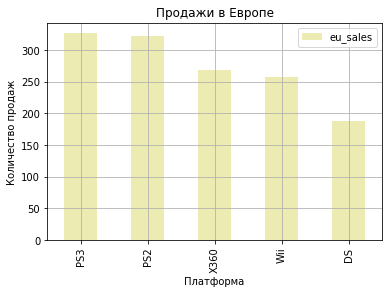

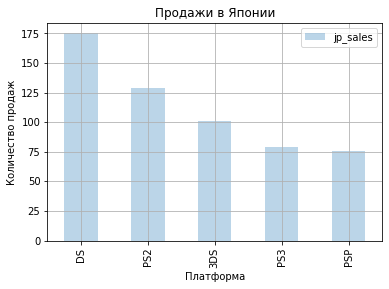

In [41]:
### 
games_data.groupby(by='platform') \
             .agg({'na_sales':'sum'}) \
             .sort_values(by='na_sales', 
                          ascending=False) \
             .head(5) \
             .plot(kind='bar',
                   alpha=0.3, 
                   color='r', 
                   grid=True)
plt.ylabel('Количество продаж')
plt.xlabel('Платформа')
plt.title('Продажи в Северной Америке')

###
games_data.groupby(by='platform') \
             .agg({'eu_sales':'sum'}) \
             .sort_values(by='eu_sales', 
                          ascending=False) \
             .head(5) \
             .plot(kind='bar', alpha=0.3, color='y', grid=True)
plt.ylabel('Количество продаж')
plt.xlabel('Платформа')
plt.title('Продажи в Европе')

###
games_data.groupby(by='platform') \
          .agg({'jp_sales':'sum'}) \
          .sort_values(by='jp_sales', 
                       ascending=False) \
          .head(5) \
          .plot(kind='bar', alpha=0.3, grid=True)

plt.ylabel('Количество продаж')
plt.xlabel('Платформа')
plt.title('Продажи в Японии');

Проверим:

In [42]:
top_sales = games_data.groupby('platform').agg({'na_sales':'sum', 'eu_sales':'sum','jp_sales':'sum','other_sales':'sum'})

In [43]:
top_na = top_sales.sort_values(by='na_sales',ascending=False).head(5)['na_sales']
top_na

platform
X360    595.74
PS2     556.84
Wii     486.87
PS3     390.13
DS      380.31
Name: na_sales, dtype: float64

In [44]:
top_eu = top_sales.sort_values(by='eu_sales',ascending=False).head(5)['eu_sales']
top_eu

platform
PS3     327.21
PS2     321.99
X360    268.32
Wii     258.32
DS      188.41
Name: eu_sales, dtype: float64

In [45]:
top_jp = top_sales.sort_values(by='jp_sales',ascending=False).head(5)['jp_sales']
top_jp

platform
DS     175.00
PS2    128.67
3DS    100.62
PS3     79.41
PSP     75.88
Name: jp_sales, dtype: float64

Если смотреть на общее количество, то в Северной Америке значительно больше денег тратят на игры. На втором месте Европа, а потом Япония

Мы нашли топ-5 самых популярных платформ в Северной Америке, Европе и Японии. Давайте найдём их долю

In [46]:
### na
[round(i/top_sales['na_sales'].sum(),2) for i in top_na.values]

[0.17, 0.16, 0.14, 0.11, 0.11]

In [47]:
### eu
[round(i/top_sales['eu_sales'].sum(),2) for i in top_eu.values]

[0.16, 0.16, 0.13, 0.13, 0.09]

In [48]:
### jp
[round(i/top_sales['jp_sales'].sum(),2) for i in top_jp.values]

[0.23, 0.17, 0.13, 0.1, 0.1]

#### Найдём предпочтительные жанры

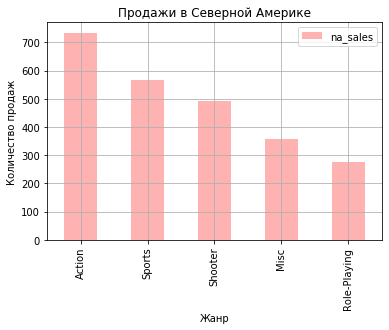

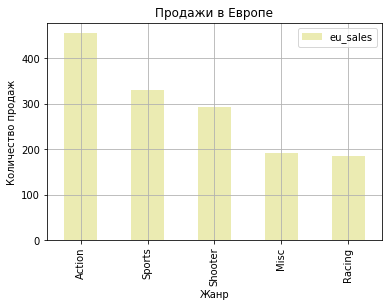

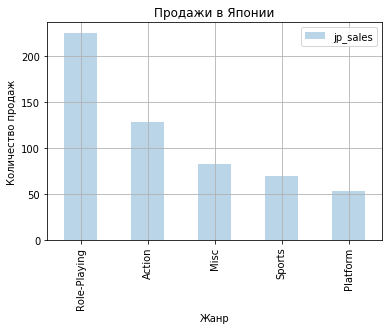

In [49]:
### 
games_data.groupby(by='genre') \
             .agg({'na_sales':'sum'}) \
             .sort_values(by='na_sales', 
                          ascending=False) \
             .head(5) \
             .plot(kind='bar',
                   alpha=0.3, 
                   color='r', 
                   grid=True)
plt.ylabel('Количество продаж')
plt.xlabel('Жанр')
plt.title('Продажи в Северной Америке')

###
games_data.groupby(by='genre') \
             .agg({'eu_sales':'sum'}) \
             .sort_values(by='eu_sales', 
                          ascending=False) \
             .head(5) \
             .plot(kind='bar', alpha=0.3, color='y', grid=True)
plt.ylabel('Количество продаж')
plt.xlabel('Жанр')
plt.title('Продажи в Европе')

###
games_data.groupby(by='genre') \
          .agg({'jp_sales':'sum'}) \
          .sort_values(by='jp_sales', 
                       ascending=False) \
          .head(5) \
          .plot(kind='bar', alpha=0.3, grid=True)

plt.ylabel('Количество продаж')
plt.xlabel('Жанр')
plt.title('Продажи в Японии');

Аналогично для жанров. Больше количество игр было продано в na, поэтому гистограмма там на больших значениях по оси y. В целом Action почти везде лидирует, равно как и Sport. Япония активнее других играет в Role-Playing

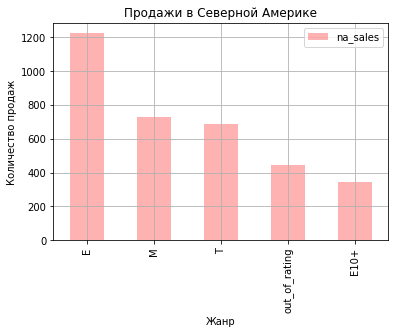

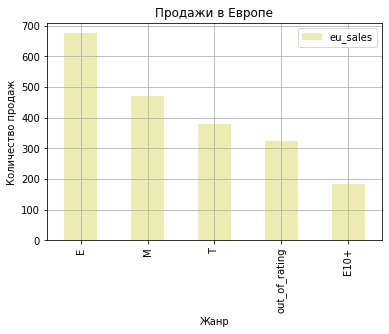

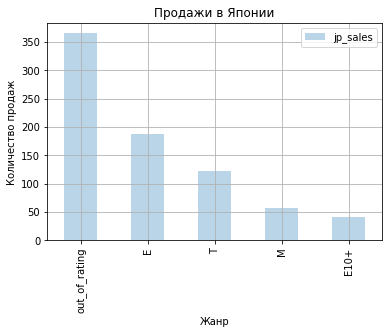

In [50]:
### 
games_data.groupby(by='rating') \
             .agg({'na_sales':'sum'}) \
             .sort_values(by='na_sales', 
                          ascending=False) \
             .head(5) \
             .plot(kind='bar',
                   alpha=0.3, 
                   color='r', 
                   grid=True)
plt.ylabel('Количество продаж')
plt.xlabel('Жанр')
plt.title('Продажи в Северной Америке')

###
games_data.groupby(by='rating') \
             .agg({'eu_sales':'sum'}) \
             .sort_values(by='eu_sales', 
                          ascending=False) \
             .head(5) \
             .plot(kind='bar', alpha=0.3, color='y', grid=True)
plt.ylabel('Количество продаж')
plt.xlabel('Жанр')
plt.title('Продажи в Европе')

###
games_data.groupby(by='rating') \
          .agg({'jp_sales':'sum'}) \
          .sort_values(by='jp_sales', 
                       ascending=False) \
          .head(5) \
          .plot(kind='bar', alpha=0.3, grid=True)

plt.ylabel('Количество продаж')
plt.xlabel('Жанр')
plt.title('Продажи в Японии');

Как видно, рейтинг E (для всех) является лидером по продажам для каждого региона.  
Далее, для Европы и Америки идёт рейтинг M (17+), для Японии же далее идёт рейтинг T (13+). Для всех стран категория игр E10+ на последнем месте по продажам.  
Соответственно, чтобы сделать игру успшеной по продажам, она должна быть доступна всем возрастам.   
Также, почему Япония редко покупает игры c T рейтингом, это свои особые традиции компьютерных игр. Играют они в своих покемонов с E, а всякие GTA не для них.

### Проведём исследование статистических показателей

Нужно посчитать:  
1) Пользовательский рейтинг для различных жанров  
2) Рейтинг критиков для различных жанров  
3) Среднее, дисперсию и стандартное отклонение  
А также построить гистограммы

In [51]:
games_data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


In [52]:
### Давайте для начала отсчечем значения с -1

In [53]:
games_scores = games_data[(games_data['critic_score'] > -1) & (games_data['user_score'] > -1)]
games_scores.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


Построим таблицу со статистическими показателями

In [54]:
games_stats = games_scores.pivot_table(index='genre',
                                       values=['critic_score','user_score'],
                                       aggfunc=[np.mean, np.var, np.std])
games_stats.head()

mean                     var                     std  \
          critic_score user_score critic_score user_score critic_score   
genre                                                                    
Action       67.751545   7.090111   201.601807   1.920211    14.198655   
Adventure    66.364341   7.183333   200.271408   2.617659    14.151728   
Fighting     69.642659   7.288643   192.058064   1.931176    13.858502   
Misc         67.314136   6.830628   219.223894   2.363233    14.806211   
Platform     69.691517   7.350900   167.749954   2.081990    12.951832   

                      
          user_score  
genre                 
Action      1.385717  
Adventure   1.617918  
Fighting    1.389668  
Misc        1.537281  
Platform    1.442910

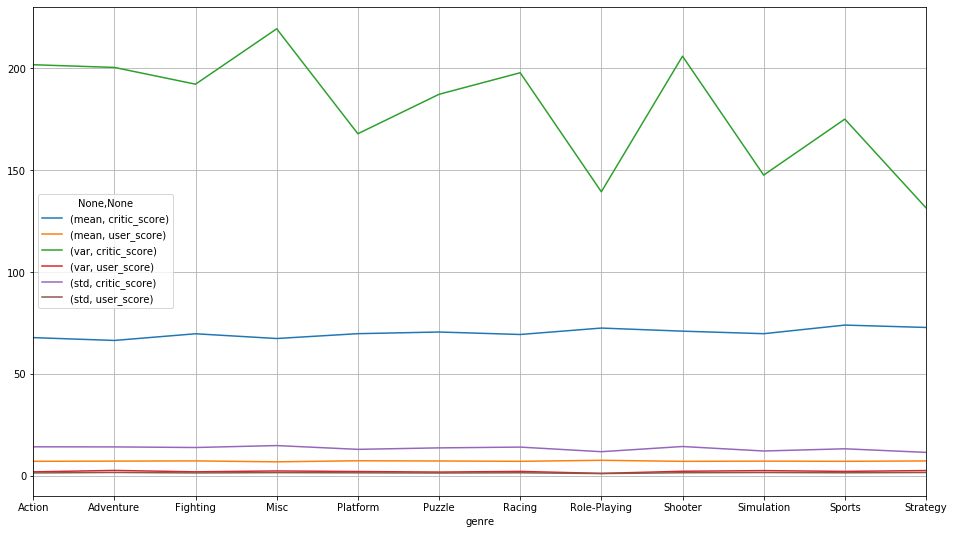

In [55]:
ax = games_stats.plot(figsize=(16,9),grid=True)
plt.xticks(list(range(games_stats.shape[0])), games_stats.index);

На графике видно, что разные жанры имеют в среднем одинаковые оценки критиков и юзеров  
Единственное, что меняется, это дисперсия для оценок критиков.

### Проверим гипотезы

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;  
Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.


#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H0: средний пользовательский рейтинг платформ Xbox One и PC одинаковый  
H1: средний пользовательский рейтинг платформ Xbox One и PC различается

Сравним дисперсии показателей:

In [56]:
XOnex_D = np.var(games_data[(games_data['platform'] == 'XOne') & (games_data['user_score'] > 0)]['user_score'])
PC_D = np.var(games_data[(games_data['platform'] == 'PC') & (games_data['user_score'] > 0)]['user_score'])
print('Дисперсия для XOne: {:.2f}'.format(XOnex_D))
print('Дисперсия для PC: {:.2f}'.format(PC_D))

Дисперсия для XOne: 1.90
Дисперсия для PC: 2.31


Как видно, дисперсии выборок отличаются, поэтому в ttest_ind укажем атрибут equal_var=False

In [57]:
alpha = 0.05

In [58]:
XOne_data = games_data[(games_data['platform'] == 'XOne') & (games_data['user_score'] > 0)]['user_score']
PC_data = games_data[(games_data['platform'] == 'PC') & (games_data['user_score'] > 0)]['user_score']

Также давайте посмотрим на распределения выборок:

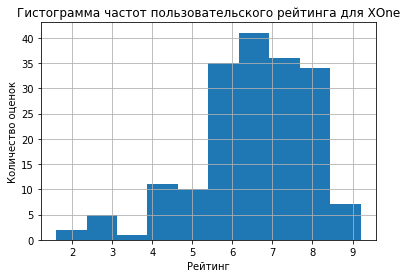

In [59]:
XOne_data.hist()
plt.xlabel('Рейтинг')
plt.ylabel('Количество оценок')
plt.title('Гистограмма частот пользовательского рейтинга для XOne');

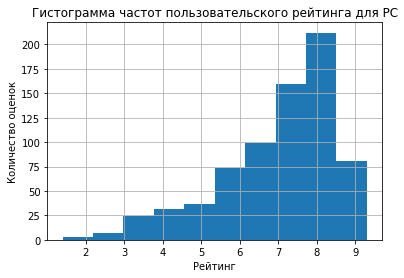

In [60]:
PC_data.hist()
plt.xlabel('Рейтинг')
plt.ylabel('Количество оценок')
plt.title('Гистограмма частот пользовательского рейтинга для PC');

В целом видно, что значения распределены нормально. Для XOne они сосредоточены вокруг 6-7, в то время как гистограмма оценок для PC распределена вокруг 8 и скошена вправо  
Нормальность распределения позволяет нам использовать ttest для проверки гипотезы

In [61]:
results = st.ttest_ind(XOne_data, PC_data, equal_var=False)

In [62]:
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 2.2075890056219328e-05
Отвергаем нулевую гипотезу


#### Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные

H0: средний пользовательский рейтинг жанров Action и Sports одинаковый  
H1: средний пользовательский рейтинг жанров Action и Sports различается  

In [63]:
action_var = np.var(games_data[(games_data['genre']=='Action') & (games_data['user_score']>0)]['user_score'])
sport_var = np.var(games_data[(games_data['genre']=='Sports') & (games_data['user_score']>0)]['user_score'])
print('Дисперсия для игр жанра Action: {:.2f}'.format(action_var))
print('Дисперсия для игр жанра Sports: {:.2f}'.format(sport_var))

Дисперсия для игр жанра Action: 2.00
Дисперсия для игр жанра Sports: 2.63


Как видно, дисперсии выборок отличаются, поэтому в ttest_ind укажем атрибут equal_var=False

In [64]:
action_data = games_data[(games_data['genre']=='Action') & (games_data['user_score']>0)]['user_score']
sports_data = games_data[(games_data['genre']=='Sports') & (games_data['user_score']>0)]['user_score']

Посмотрим на распределения

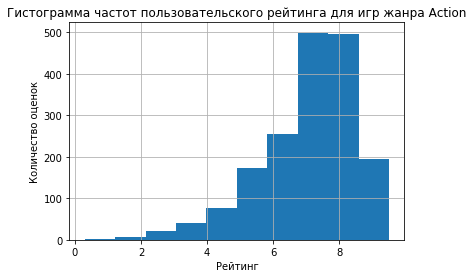

In [65]:
action_data.hist()
plt.xlabel('Рейтинг')
plt.ylabel('Количество оценок')
plt.title('Гистограмма частот пользовательского рейтинга для игр жанра Action');

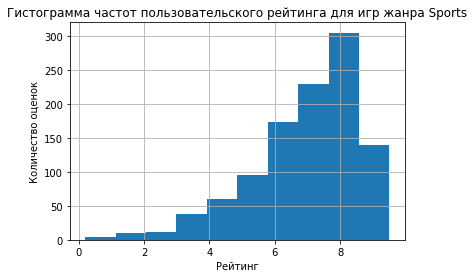

In [66]:
sports_data.hist()
plt.xlabel('Рейтинг')
plt.ylabel('Количество оценок')
plt.title('Гистограмма частот пользовательского рейтинга для игр жанра Sports');

Гистограммы частот распределены нормально, можем использовать t-test

In [67]:
results2 = st.ttest_ind(action_data, sports_data, equal_var=False)

In [68]:
print(f'p-значение равно: {results2.pvalue}')

if results2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Принимаем нулевую гипотезу')

p-значение равно: 0.07686681371741208
Принимаем нулевую гипотезу


<b>Результаты исследования:</b>  
1. Необходимо для выпуска выбирать платформу, которая проживёт ещё какое-то время. Средний срок жизни платформы - это 7,5 лет, а частота их обновления - 6 лет. Скорее всего стоит присмотреться к следующим платформам:  PS3, Xbox 360 и PS4  
2. Лучше всего выходить на рынки в Северной Америке, так как они тратят на игры больше всего денег. В таком случае отказываемся от WiU, заменив её на Wii  
3. Если мы выбираем выходить на рынки NA, то выпускаем игру в жанре Action или Sports.  
4. Рейтинг для игры ставим E или M.   
Если мы сделаем всё, как описано в инструкции, то срубим много баблинского и станем очень богатыми))